# Tweeezr Trap Analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.ndimage import center_of_mass
from scipy.ndimage import measurements
from scipy.stats import norm
import numpy as np
import random
import os
import cv2
os.chdir("../../")

In [2]:
# Plot configs
def plot_configs(ax):
    plt.rcParams['text.usetex'] = True

    # Set bourder line
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    # Tick parameters
    ax.tick_params(axis = 'both', which = 'major', length = 6, width = 1, direction = 'in', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', length = 4, width = 1, direction = 'in', labelsize = 16)
    ax.tick_params(labelbottom = True, labeltop = False, labelleft = True, labelright = False,
                     bottom = True, top = True, left = True, right = True)
    ax.yaxis.set_tick_params(right='on',which='both')
    return ax

def color_settings(n_colors):
    return iter(cm.Blues(np.linspace(0.3, 1, n_colors)))

filled_marker_style_blue = dict(marker='o', linestyle='None', markersize=5,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:blue')

filled_marker_style_red = dict(marker='o', linestyle='None', markersize=5,
                           color='darkgrey',
                           markerfacecolor='lightcoral',
                           markerfacecoloralt='lightcoral',
                           markeredgecolor='tab:red')                    

In [3]:
def imageProcess(path):
    """
    Preprocess the aquired EMCCD trap image for future uses.
    """
    fig, axs = plt.subplots(1, 3, figsize=(16,8))
    fig.tight_layout()
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image_original = image.copy()
    axs[0].set_title("Raw Target")
    axs[0].imshow(image, 'gray')

    # Make image binary
    thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    axs[1].set_title("Threashold Target")
    axs[1].imshow(thresh, 'gray')

    # Close image to get blocked patterns, or "binary image", trap color = 255
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    axs[2].set_title("Opened Target")
    axs[2].imshow(closing, 'gray')

    return image_original, closing 

def detectTrapLocation(path):
    """
    Detecting trap locations from aquired EMCCD camera images.
    """
    image_original, image_processed = imageProcess(path)
    blob_params = cv2.SimpleBlobDetector_Params()

    # images are converted to many binary b/w layers. Then 255 searches for dark blobs, 0 searches for bright blobs. Or you set the filter to "false", then it finds bright and dark blobs, both.
    blob_params.filterByColor = True
    blob_params.blobColor = 255

    # Extracted blobs have an area between minArea (inclusive) and maxArea (exclusive).
    blob_params.filterByArea = True
    blob_params.minArea = 1 # Highly depending on image resolution and dice size
    blob_params.maxArea = 1500. # float! Highly depending on image resolution.

    # A critical step to turn off all the filters.
    blob_params.filterByArea = False  # Can be changed to compute rel to diffraction limit
    blob_params.filterByCircularity = False
    blob_params.filterByConvexity = False
    blob_params.filterByInertia = False

    # Create a simple blob detector
    detector = cv2.SimpleBlobDetector_create(blob_params)

    # Detect blobs
    blobs = detector.detect(image_processed)

    
    return image_original, blobs

def extract_trap(image, keypoints, crop_size):
    #raise NotImplementedError()
    # Make the figure and subplots.
    # Gather helper variables and set the min and max of all the subplots.
    M = int(np.ceil(np.sqrt(len(keypoints))))
    
    # Plot zoom in and cropped results
    plt.figure(figsize=(12, 12))
    for n, key_point in enumerate(keypoints):
        ax = plt.subplot(M, M, n + 1)
        ax.imshow(
            image[int(key_point.pt[0] - (crop_size/2)):int(key_point.pt[0] + (crop_size/2)), int(key_point.pt[1] - (crop_size/2)):int(key_point.pt[1] + (crop_size/2))],
            interpolation='none',
            cmap='gray'
        )
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

    plt.show()

def gaussian_2d(xy, A, x0, y0, sigma_x, sigma_y):
    x, y = xy
    gaussian = A * np.exp(-(x - x0)**2 / (2 * sigma_x**2) - (y - y0)**2 / (2 * sigma_y**2))
    return gaussian.ravel()

def initial_guess_with_moment(data):
    """
    Returns initial guesses for ( A, x0, y0, sigma_x, sigma_y) the gaussian parameters 
    of a 2D distribution by calculating its moments.
    """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x0 = (X*data).sum()/total
    y0 = (Y*data).sum()/total
    col = data[:, int(y0)]
    sigma_x = np.sqrt(np.abs((np.arange(col.size)-x0)**2*col).sum()/col.sum())
    row = data[int(x0), :]
    sigma_y = np.sqrt(np.abs((np.arange(row.size)-y0)**2*row).sum()/row.sum())
    A = data.max()
    return A, x0, y0, sigma_x, sigma_y

def gaussian_2d_fit(image):
    """
    Perform Gaussian fit to the trap array data.    
    """
    # Smooth image for better performance
    smoothed_image = gaussian_filter(image, sigma=2)

    # Guess a initial condition for data fit
    initial_guess = initial_guess_with_moment(smoothed_image)

    y, x = np.indices(image.shape)
    xy = (x, y)

    image_flat = image.flatten()

    popt, _ = curve_fit(gaussian_2d, xy, image_flat, p0=initial_guess)
    fitted_data = gaussian_2d(xy, *popt).reshape(image.shape)
        
    return popt, x, y, fitted_data

def analysis(fig, image, popt, x, y, fitted_data, blob_idx, blob_centers, sample, plot_option, analysis_plot_option):
    ## Analsis Section
    ###
    # Determine the spot size (waist), good approximation when sigma_x~sigma_y
    sigma_x = round(popt[3], 2)
    sigma_y = round(popt[4], 2)
    spot_size = sigma_x + sigma_y
    
    # Determine the sharpness
    sharpness = ((image.sum())**2) / ((image**2).sum())

    # Determine trap depth
    trap_depth = popt[0]


    ## Plot Section
    ###
    # If we just want to plot some samples
    if plot_option == 'sample':
        if blob_idx in sample:
            pass
        else:
            return spot_size, sharpness, trap_depth

    # If we want to plot all the traps, just continue
    elif plot_option == 'all':
        pass


    # Onlt plot traps
    if analysis_plot_option == 'trap':
        ax = fig.subplots()
        ax.imshow(
            image,
            interpolation='none',
            cmap='gray'
        )
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

    # Plot with gaussian fit
    elif analysis_plot_option == 'analysis':
        # Main fig
        ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
        ax.set(aspect=1)
        ax.imshow(image, cmap='gray', origin='lower', extent=(0, image.shape[1], 0, image.shape[0]))
        ax.contour(x, y, fitted_data, colors='r', linewidths=1)
        text = r'$\sigma_x = $' + f'{sigma_x}\n' + r'$\sigma_y = $' + f'{sigma_y}'
        ax.text(0.75, 0.15, text, horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes, color = 'r', fontsize = 18)
        ax.set_title(r'Trap ' + f'{blob_idx}: ' + f'{int(blob_centers[0, blob_idx]), int(blob_centers[1, blob_idx])}')

        # Side figs, plot data points and the corresponding gaussian fit
        ax_fitx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
        ax_fitx.tick_params(axis="x", labelbottom=False)
        ax_fitx.plot(x[0, :], image[int(popt[1]), :], **filled_marker_style_blue)
        ax_fitx.plot(x[0, :], fitted_data[int(popt[1]), :], '-k')

        ax_fity = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
        ax_fity.tick_params(axis="y", labelleft=False)
        ax_fity.plot(image[:, int(popt[2])], y[:, 0], **filled_marker_style_blue)
        ax_fity.plot(fitted_data[int(popt[2]), :], y[:, 0], '-k')

    else:
        pass   

    return spot_size, sharpness, trap_depth
    

def trap_statistics(img_path): 
    
    image_result, blobs = detectTrapLocation(img_path)
    
    # Get blob statistics.
    blob_count = len(blobs)
    blob_centers = np.zeros((2, blob_count))
    blob_diameters = np.zeros(blob_count)
    blob_spot_size = np.zeros(blob_count)
    blob_sharpness = np.zeros(blob_count)
    blob_trap_depth = np.zeros(blob_count)

    for (blob_idx, blob) in enumerate(blobs):
        blob_centers[:, blob_idx] = blob.pt
        blob_diameters[blob_idx] = blob.size

    print(f'Number of traps: {blob_count}\n')

    ## Plot out identified traps
    ###
    fig, ax = plt.subplots(figsize=(10, 8), dpi = 100)
    ax.set_title("Trap Location")
    ax.imshow(image_result, cmap='gray')

    for blob_idx in range(blob_count):
        patch = matplotlib.patches.Circle(
            (float(blob_centers[0, blob_idx]), float(blob_centers[1, blob_idx])),
            radius=float(blob_diameters[blob_idx]),
            color="red",
            linewidth=1,
            fill=None
        )
        ax.add_patch(patch)
    plt.show()

    plot_option = 'sample'
    analysis_plot_option = 'analysis'

    # Analysis Plot
    ###
    if plot_option == 'all':
        # Plot zoom in the identified traps and cropped results
        M = int(np.ceil(np.sqrt(blob_count)))
        sample_index = None

    elif plot_option == 'sample':
        # Plot zoom in the identified traps and cropped results
        sample_num = 4
        M = int(np.ceil(np.sqrt(sample_num)))
        # Ramdomly choose which trap to plot
        sample = random.sample(list(range(blob_count)), sample_num)
        sample.sort()

    else:
        M = None
        sample = None
        subfig = None

    fig = plt.figure(figsize=(15, 13), layout='constrained')
    
    fig.suptitle('Gaussian Fit')
    subfigs = fig.subfigures(M, M)

    # Iterate through all traps
    for blob_idx in range(blob_count):
        crop_size = blob_diameters[blob_idx]/2 + 25
        array_spot = image_result[(int(blob_centers[1, blob_idx]) - int(crop_size/2)):(int(blob_centers[1, blob_idx]) + int(crop_size/2)), ((int(blob_centers[0, blob_idx])) - int(crop_size/2)):(int(blob_centers[0, blob_idx]) + int(crop_size/2))]
        popt, x, y, fitted_data = gaussian_2d_fit(array_spot)

        if plot_option == 'all':  
            subfig = subfigs[int(np.floor(blob_idx/M)), blob_idx - int(np.floor(blob_idx/M)) * M]
        
        elif plot_option == 'sample':  
            if blob_idx in sample:
                sample_idx = sample.index(blob_idx)
                subfig = subfigs[int(np.floor(sample_idx/M)), sample_idx - int(np.floor(sample_idx/M)) * M]
            else:
                subfig = None

        # Analysis
        spot_size, sharpness, trap_depth = analysis(subfig, array_spot, popt, x, y, fitted_data, blob_idx, blob_centers, sample, plot_option, analysis_plot_option )
        blob_spot_size[blob_idx] = spot_size
        blob_sharpness[blob_idx] = sharpness
        blob_trap_depth[blob_idx] = trap_depth

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi = 100)
    num_bins = 10
    
    # Fit a normal distribution to
    # the data:
    # mean and standard deviation
    

    ax[0].hist(blob_spot_size, num_bins, edgecolor='black', alpha=0.75)
    blob_spot_size_mu, blob_spot_size_std = norm.fit(blob_spot_size) 
    blob_spot_size_xmin, blob_spot_size_xmax = ax[0].get_xlim()
    blob_spot_size_bin_width = (blob_spot_size_xmax - blob_spot_size_xmin) / num_bins
    blob_spot_size_x = np.linspace(blob_spot_size_xmin, blob_spot_size_xmax, 100)
    ax[0].plot(blob_spot_size_x, 
               norm.pdf(blob_spot_size_x,  
                        blob_spot_size_mu,  
                        blob_spot_size_std) * blob_count * blob_spot_size_bin_width,
                '--k')
    ax[0].set_xlabel(r'$w_{0} (1/e^{2})$')
    ax[0].set_ylabel(r'Counts')
    text = r'$w_{0} = $' + f'{round(blob_spot_size_mu, 2)}' + r'$\pm$' + f'{round(blob_spot_size_std ,2)}'
    ax[0].text(0.8, 0.9, 
               text, 
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[0].transAxes, 
               color = 'k',
               fontsize = 10)
    

    ax[1].hist(blob_sharpness, num_bins, edgecolor='black', alpha=0.75)
    blob_sharpness_mu, blob_sharpness_std = norm.fit(blob_sharpness) 
    blob_sharpness_xmin, blob_sharpness_xmax = ax[1].get_xlim()
    blob_sharpness_x = np.linspace(blob_sharpness_xmin, blob_sharpness_xmax, 100)
    blob_sharpness_bin_width = (blob_sharpness_xmax - blob_sharpness_xmin) / num_bins
    ax[1].plot(blob_sharpness_x, 
               norm.pdf(blob_sharpness_x,  
                        blob_sharpness_mu,  
                        blob_sharpness_std) * blob_count * blob_sharpness_bin_width, '--k')
    ax[1].set_xlabel(r'$S = (\Sigma I)^{2}/\Sigma I^{2})$')
    ax[1].set_ylabel(r'Counts')
    text = r'$S = $' + f'{round(blob_sharpness_mu, 2)}' + r'$\pm$' + f'{round(blob_sharpness_std ,2)}'
    ax[1].text(0.8, 0.9, 
               text, 
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[1].transAxes, 
               color = 'k',
               fontsize = 10)
    

    ax[2].hist(blob_trap_depth/blob_trap_depth.sum(), num_bins, edgecolor='black', alpha=0.75)
    blob_trap_depth_mu, blob_trap_depth_std = norm.fit(blob_trap_depth/blob_trap_depth.sum()) 
    blob_trap_depth_xmin, blob_trap_depth_xmax = ax[2].get_xlim()
    blob_trap_depth_x = np.linspace(blob_trap_depth_xmin, blob_trap_depth_xmax, 100)
    blob_trap_depth_bin_width = (blob_trap_depth_xmax - blob_trap_depth_xmin) / num_bins
    ax[2].plot(blob_trap_depth_x, 
               norm.pdf(blob_trap_depth_x,  
                        blob_trap_depth_mu,  
                        blob_trap_depth_std) * blob_count * blob_trap_depth_bin_width, '--k')
    ax[2].set_xlabel(r'$U_{0}/ \langle U_{0} \rangle$')
    ax[2].set_ylabel(r'Counts')
    text = r'$U_{0}/ \langle U_{0} \rangle = $' + f'{round(blob_trap_depth_mu, 3)}' + r'$\pm$' + f'{round(blob_trap_depth_std ,3)}'
    ax[2].text(0.8, 0.9, 
               text, 
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=ax[2].transAxes, 
               color = 'k',
               fontsize = 10)
    
    fig.tight_layout()
    plt.show()

Number of traps: 441



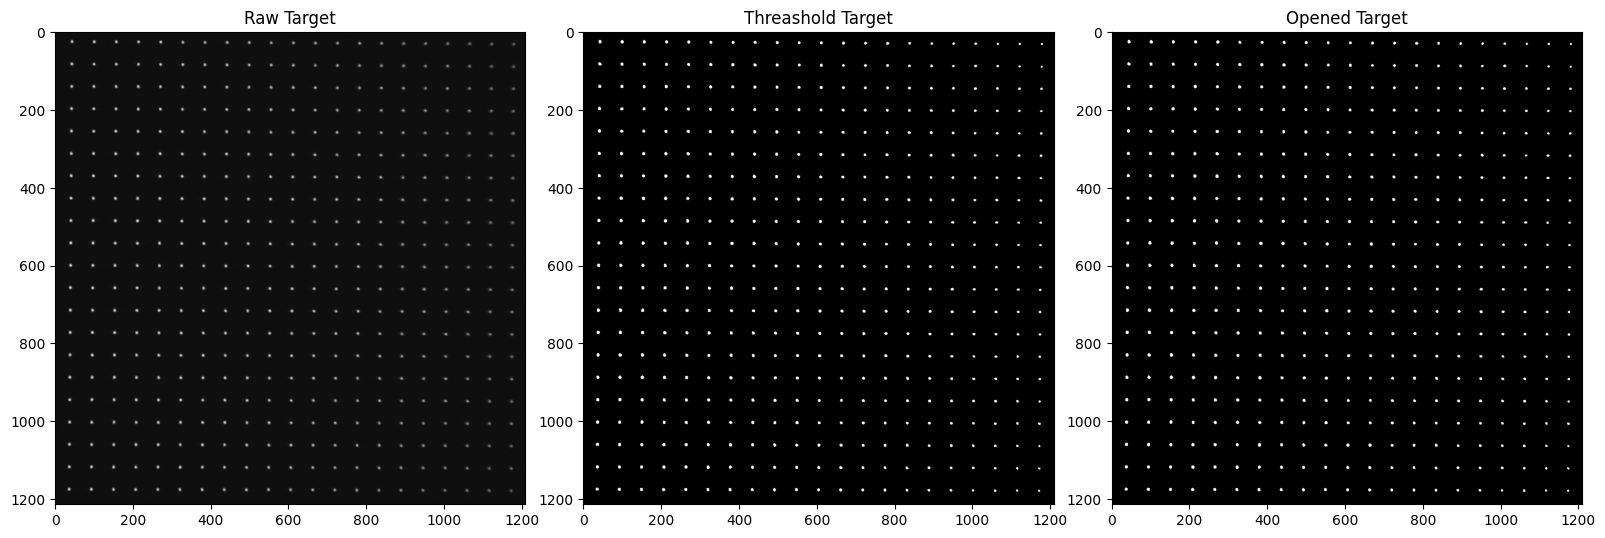

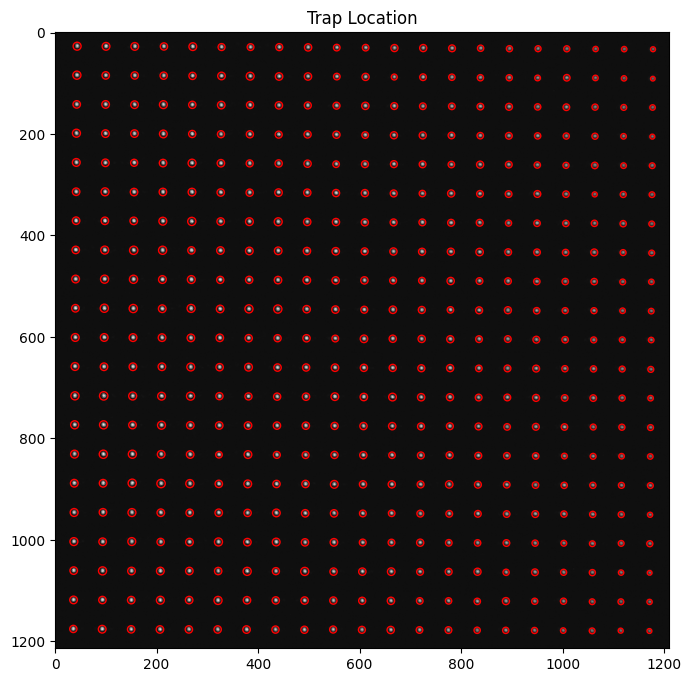

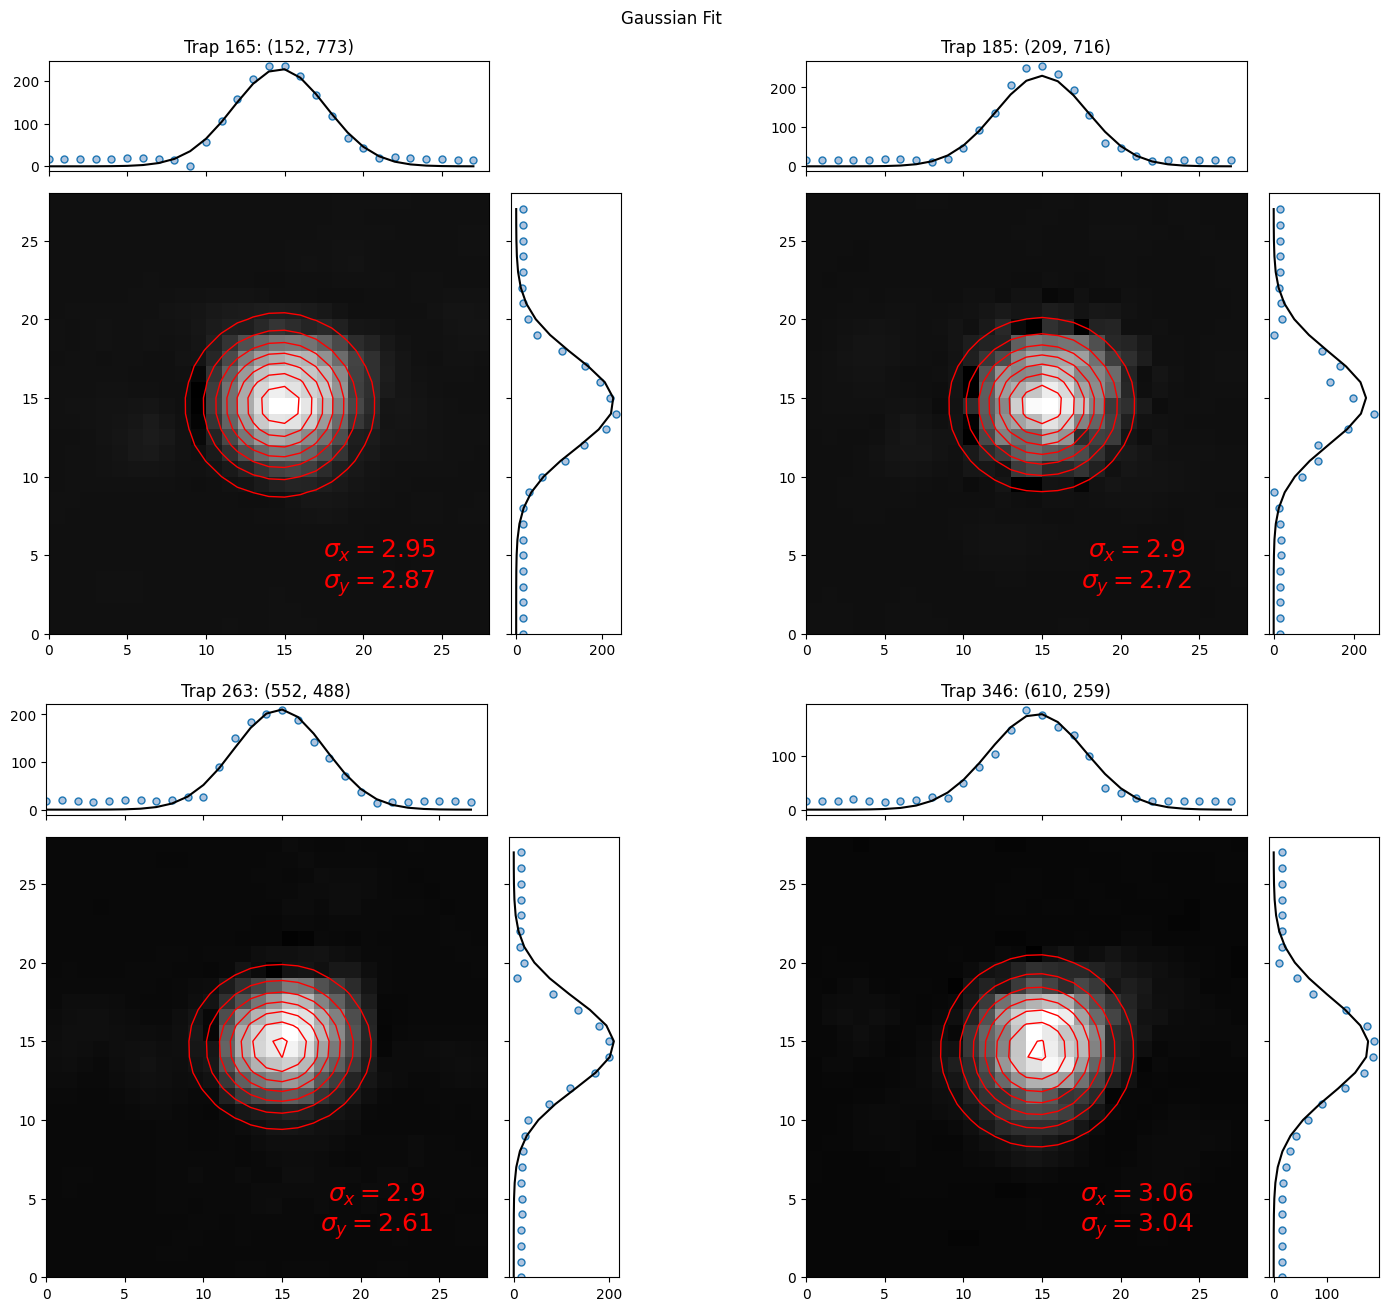

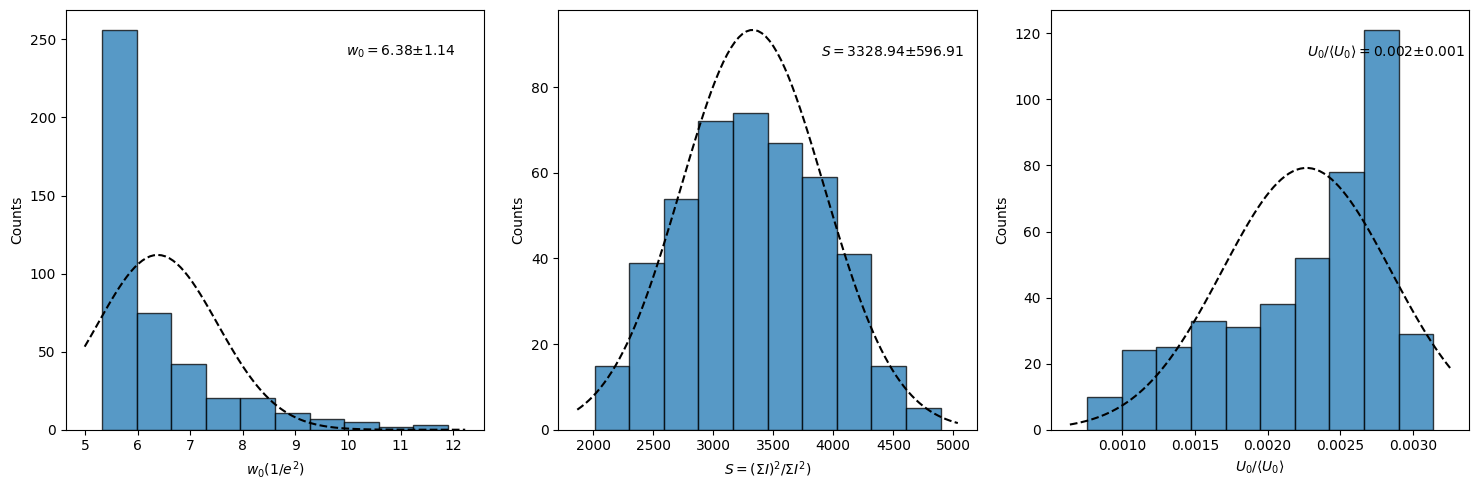

In [4]:
trap_statistics('./Experiments/aquired_trap_img/24x24_great_cropped.png')